# Creating a simple Bayesian model
##  Using the data from following table create a model predicting number of passenger deaths.
Use poisson distribution in two variants 
1. The rate is constant for all years and not depending on anything.
2. The intensity is constant, but rate is a product of intensity and miles flown.

Select appropriate priors, perform prior predictive checks, fit the model and using posterior predictive distribution predict the death rates from the model.

In [1]:
import pystan
import stan_utility

import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

st=plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [2]:
light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [3]:
dts=[24,734,25,516,31,754,31,877,22,814,21,362,26,764,20,809,16,223,22,1066]
c1=dts[::2]
c2=dts[1::2]

airline_data=pd.DataFrame({'Year':[1976,1977,1978,1979,1980,1981,1982,1983,1984,1985],
                           'Fatal accidents':c1,  
                           'Passenger deaths':c2,
                           'Death rate':[0.19,0.12,0.15,0.16,0.14,0.06,0.13,0.13,0.03,0.15]}).set_index('Year')

airline_data['Miles flown [100 mln miles]']=np.round(airline_data['Passenger deaths']/airline_data['Death rate'])

## generation of vector for plotting samples under histograms
death=[]
dta_cnt=[]
for k in airline_data['Passenger deaths']:  
    dta_cnt.append(-(1.+death.count(k)))
    death.append(k)
dta_cnt=np.array(dta_cnt)

airline_data

,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
Year,,,,
1976,24,734,0.19,3863.0
1977,25,516,0.12,4300.0
1978,31,754,0.15,5027.0
1979,31,877,0.16,5481.0
1980,22,814,0.14,5814.0
1981,21,362,0.06,6033.0
1982,26,764,0.13,5877.0
1983,20,809,0.13,6223.0
1984,16,223,0.03,7433.0


In [4]:
print(airline_data['Passenger deaths'])
print(airline_data['Passenger deaths'].mean())

Year
1976     734
1977     516
1978     754
1979     877
1980     814
1981     362
1982     764
1983     809
1984     223
1985    1066
Name: Passenger deaths, dtype: int64
691.9


## Part 1 - The rate is constant for all years and not depending on anything
Let's assume that plane accident occure every 2 months. Knowing that Boeing 737 is the most common used plane by airlines and it carries 150 passengers on average, it is assumed, that every year 900 deaths are caused by plane crashes.

For poisson distribution we have mean of $\lambda$ and standard deviation of $\sqrt{\lambda}$. Approximately in order to have no more than 1% probability $\lambda$ should fulfill
$$\lambda+3\sqrt{\lambda}\approx900$$

In [5]:
root_of_lam=np.polynomial.polynomial.polyroots([-900.,3.,1.])
lam_ub=np.round(root_of_lam[root_of_lam>0]**2)
print(lam_ub)

[814.]


Prior prediction is based on consideration presentes above, moreover wide sigma is selected to assure higher rate

In [6]:
model_ppc=stan_utility.compile_model('stan_model/passenger_ppc.stan')

Using cached StanModel


In [7]:
R =1000
sim_model_ppc=model_ppc.sampling(data=dict(),
                                   iter=R,
                                   warmup=0,
                                   refresh=R,
                                   algorithm='Fixed_param',
                                   seed=43541)

In [8]:
params_sim=sim_model_ppc.extract()
lambda_sim=params_sim['lambda']
deaths_sim=params_sim['deaths']

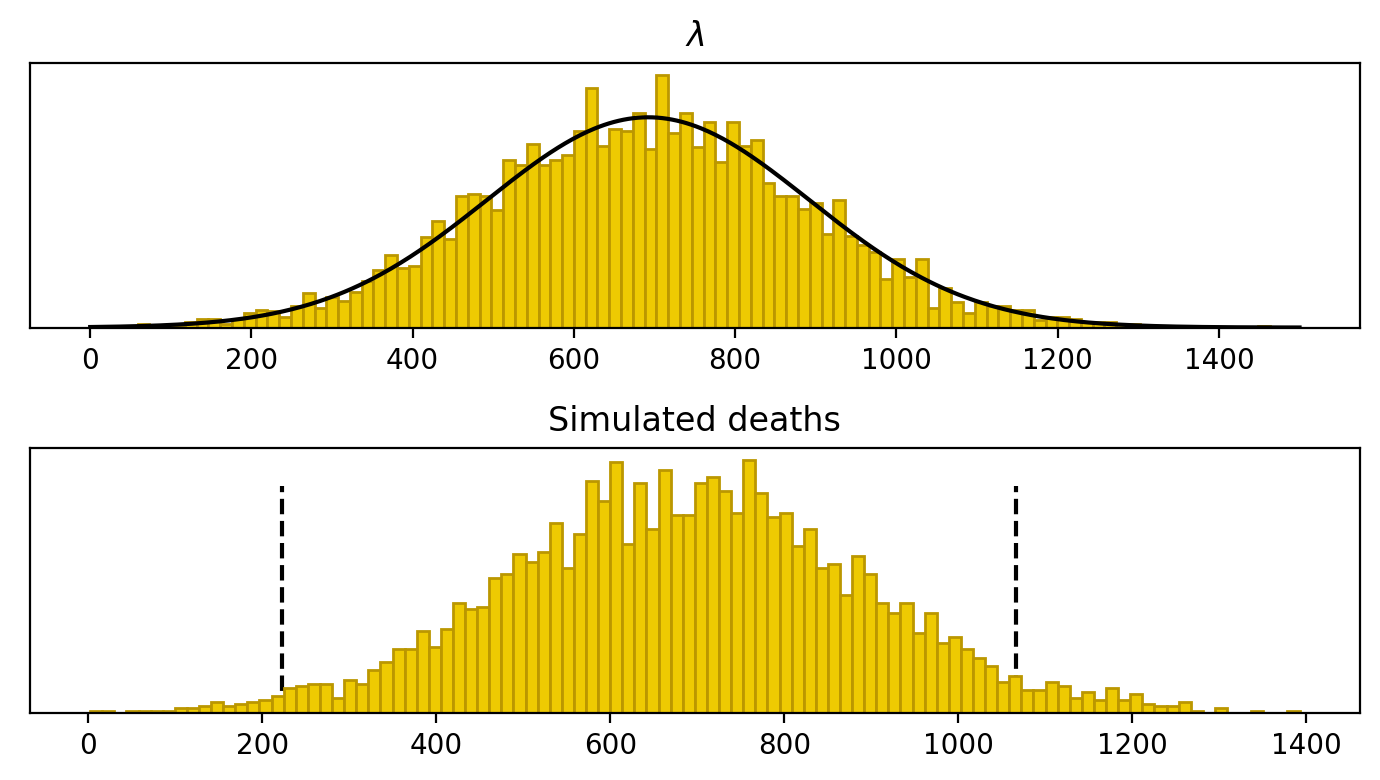

In [9]:
fig = plt.figure(figsize=(7, 4))

gs = fig.add_gridspec(2,1)
ax1 = fig.add_subplot(gs[1])
ax1.hist(deaths_sim,bins=100,color=dark,edgecolor=dark_highlight,density=True)
ax1.vlines([airline_data['Passenger deaths'].min(),airline_data['Passenger deaths'].max()],
           ymin=0,ymax=2e-3,linestyle='--',color='black',zorder=1)
# ax1.set_yticks([])
ax1.set_title('Simulated deaths')

ax2 = fig.add_subplot(gs[0])
ax2.hist(lambda_sim,bins=100,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,1500,500)
y=stats.norm.pdf(x,loc=692,scale=200)
ax2.plot(x,y,'black')
ax2.set_title('$\lambda$')
ax1.set_yticks([])
ax2.set_yticks([])

fig.tight_layout()
plt.show()

Proposed prior seems to correct. Simulated number of deaths is mostly in range of minimum and maximum value from data.

In [10]:
model_fit=stan_utility.compile_model('stan_model/passenger_fit.stan')

Using cached StanModel


In [11]:
fit=model_fit.sampling(data=dict(N=len(airline_data['Passenger deaths']), passenger_deaths=airline_data['Passenger deaths']), seed=28052020)

In [12]:
az.summary(fit,var_names=['lambda'], round_to=2, kind='stats')

,mean,sd,hpd_3%,hpd_97%
lambda,692.61,8.37,678.24,709.34


In [13]:
params_fit=fit.extract()
lambda_fit=params_fit['lambda']
deaths_pred=params_fit['passenger_death']

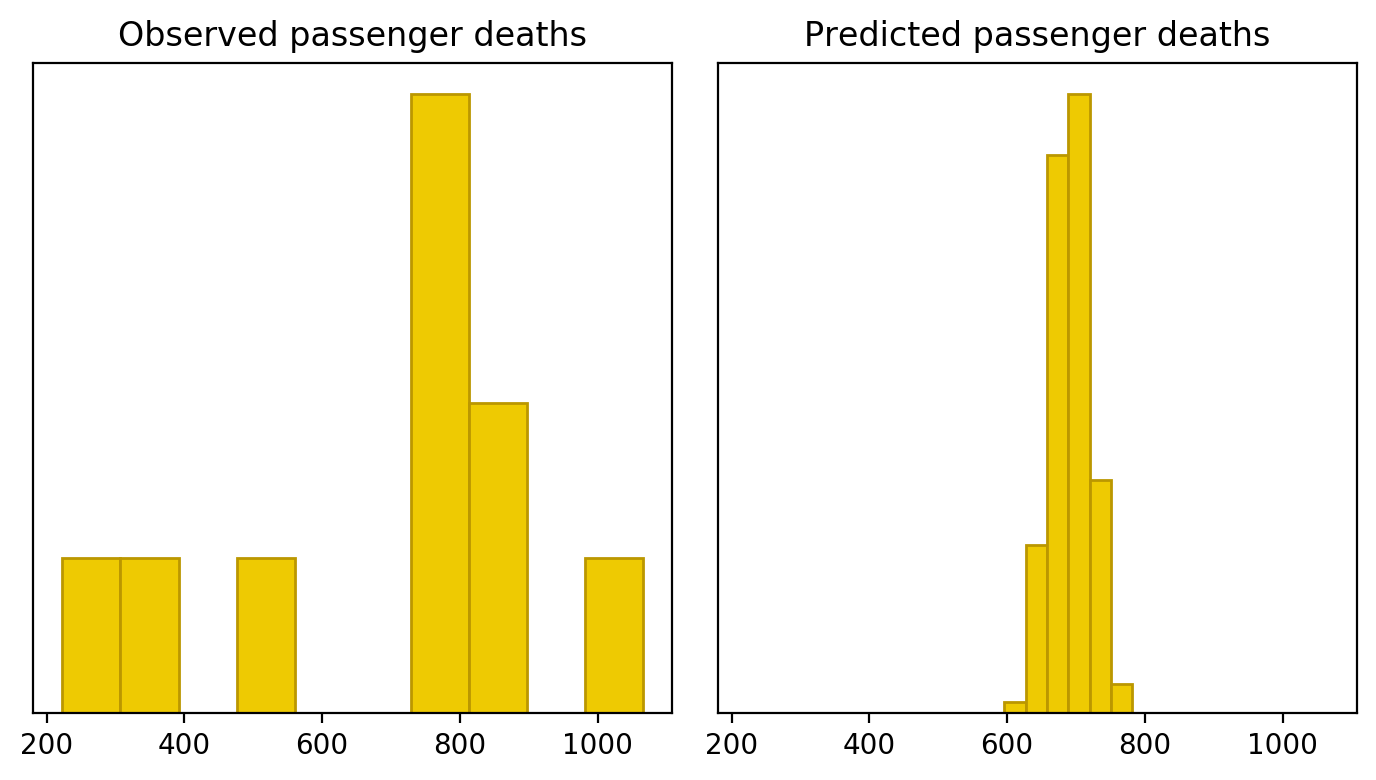

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4),sharex=True)
ax1=axes[0]
ax1.hist(airline_data['Passenger deaths'],color=dark,edgecolor=dark_highlight,density=True)
ax1.set_title('Observed passenger deaths')
ax1.set_yticks(());

ax2=axes[1]
ax2.hist(deaths_pred,bins=6,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title('Predicted passenger deaths')
ax2.set_yticks(());
fig.tight_layout()

plt.show()

Simulated model does not cover significantly. Model presents situation when passenger deaths are focused in range from 600 to 800, whereas real data set is not focused at this value. We can assume that probability of the biggest death rate match.

## Part 2 - The intensity is constant, but rate is a product of intensity and miles flown